In [22]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.integrate import simps
from scipy import interpolate, integrate
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from matplotlib import gridspec
import pyabf
import pingouin as pg
from scipy.interpolate import interp1d
import math

# Add custom scripts folder to sys.path
sys.path.append(r"E:\Dropbox (Weizmann Institute)\Lab\Code\Python Scripts Jupyter")
from entities_v2 import GCaMPData, LimbData, Frame, Clip, Experiment

CONFIGURATION & CONSTANTS

In [23]:
# Data folder (pkl files)
DATA_FOLDER = r'Z:\UriMons\Fiber Photometry\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles'

In [24]:
# CONFIGURATION & CONSTANTS
# Data folder (pkl files)
DATA_FOLDER = r'Z:\UriMons\Fiber Photometry\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles'
# Sampling and peak detection parameters
FS = 50  # Hz for GCaMP data
GROOMING_FPS = 30  # Frames per second for grooming annotations
PRETRIGGER_WINDOW = 0.1 * FS
POSTTRIGGER_WINDOW = 0.75 * FS
THRESH_MIN = 1
THRESH_MAX = 10
THRESH_PROMINENCE = 2
THRESH_MIN_WIDTH = 10 * (FS / 1000)
BIN_SIZE = 3000  # Updated bin size to match new phase mapping, 3000 = 1 min, 15000 = 5 min, 30000 = 10 min

# Plotting parameters (adjustable)
MARKER_SIZE = 8
LINE_WIDTH = 2
TITLE_FONTSIZE = 16
AXIS_LABEL_FONTSIZE = 14
LEGEND_FONTSIZE = 12
TICK_FONTSIZE = 12


In [25]:
# ===== Unified phase mapping (aligned with BIN_SIZE) =====
# Must match the window used in get_gcamp_data_Z_score(end_frame=150000)
TOTAL_FRAMES = 150_000          # analyze 0..149,999
N_BINS       = math.ceil(TOTAL_FRAMES / BIN_SIZE)
BIN_STARTS   = list(range(0, TOTAL_FRAMES, BIN_SIZE))

# --- Choose how to label bins ---
# 'custom'    -> use your own list of labels (must have N_BINS entries) --> good for 10 phases
# 'phase'     -> auto "P1", "P2", etc... --> good for 5 phases
# 'timerange' -> auto "start_s–end_s" (in seconds) --> good for time bins 
LABEL_MODE = 'timerange'  # 'custom' | 'phase' | 'timerange'

# If LABEL_MODE == 'custom', define exactly N_BINS labels here (left → right):
# With BIN_SIZE = 15000 and TOTAL_FRAMES = 150000 → N_BINS = 10
CUSTOM_LABELS = [
    "BL 1", "BL 2",
    "Stress 1", "Stress 2",
    "PS 1", "PS 2", "PS 3", "PS 4", "PS 5", "PS 6",
]

# --- Build PHASE_MAPPING keyed by bin start frame ---
PHASE_MAPPING = {}
for i, start in enumerate(BIN_STARTS):
    if LABEL_MODE == 'custom':
        if len(CUSTOM_LABELS) != N_BINS:
            raise ValueError(
                f"CUSTOM_LABELS must have {N_BINS} items (has {len(CUSTOM_LABELS)})."
            )
        label = CUSTOM_LABELS[i]
    elif LABEL_MODE == 'phase':
        label = f"P{i+1}"
    elif LABEL_MODE == 'timerange':
        start_s = start // FS
        end_s   = min(start + BIN_SIZE, TOTAL_FRAMES) // FS
        label   = f"{start_s}-{end_s}s"
    else:
        raise ValueError("LABEL_MODE must be 'custom', 'phase', or 'timerange'.")
    PHASE_MAPPING[start] = label

# --- (Optional) helper to fetch a label for an arbitrary bin_start) ---
def phase_label_from_start(start_frame: int) -> str:
    """Return matching phase label for a bin start (falls back to 'Phase <start>')."""
    return PHASE_MAPPING.get(start_frame, f"Phase {start_frame}")

# --- (Optional) quick sanity check ---
print(f"BIN_SIZE={BIN_SIZE} frames | TOTAL_FRAMES={TOTAL_FRAMES} | N_BINS={N_BINS}")
print("First 5 labels:", [PHASE_MAPPING[s] for s in BIN_STARTS[:5]])
# =========================================================


BIN_SIZE=3000 frames | TOTAL_FRAMES=150000 | N_BINS=50
First 5 labels: ['0-60s', '60-120s', '120-180s', '180-240s', '240-300s']


In [26]:
# DATA LOADING & GROUPING
def load_experiments(data_folder):
    loaded_objects = []
    for file in os.listdir(data_folder):
        if file.endswith(".pkl"):
            file_path = os.path.join(data_folder, file)
            with open(file_path, 'rb') as f:
                loaded_object = pickle.load(f)
                loaded_objects.append(loaded_object)
            print(f"Loaded: {file}")
    print(f"Total .pkl files loaded: {len(loaded_objects)}")
    return loaded_objects

def get_sapap_genotype(genotype_string):
    if "Sapap(" in genotype_string:
        start_index = genotype_string.find("Sapap(") + len("Sapap(")
        end_index = genotype_string.find(")", start_index)
        return genotype_string[start_index:end_index]
    return None

def separate_groups(loaded_objects):
    group_WT, group_KO = [], []
    for obj in loaded_objects:
        genotype = get_sapap_genotype(obj.Genotype)
        if genotype == "WT":
            group_WT.append(obj)
        elif genotype == "KO":
            group_KO.append(obj)
        else:
            print(f"Warning: Unknown or missing Sapap genotype for mouse ID {obj.Mouse_id}")
    print(f"Number of WT mice: {len(group_WT)}")
    print(f"Number of KO mice: {len(group_KO)}")
    return group_WT, group_KO

# GCaMP DATA PROCESSING & PLOTTING
def process_gcamp_data(group):
    filtered_data = {}
    for obj in group:
        try:
            gcamp_z_score, time_seconds = obj.get_gcamp_data_Z_score(start_frame=0, end_frame=150000)
            filtered_data[obj.Mouse_id] = gcamp_z_score
            print(f"Processed GCaMP data for mouse ID {obj.Mouse_id}")
        except Exception as e:
            print(f"Error processing GCaMP data for mouse ID {obj.Mouse_id}: {e}")
    return filtered_data

def plot_gcamp_data(filtered_data_dict, group_name):
    num_mice = len(filtered_data_dict)
    if num_mice == 0:
        print(f"No data available for {group_name}. Skipping plot.")
        return

    ncols = 4
    nrows = (num_mice // ncols) + (1 if num_mice % ncols else 0)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
    axes = axes.flatten() if num_mice > 1 else [axes]

    for idx, (mouse_id, data_array) in enumerate(filtered_data_dict.items()):
        axes[idx].plot(data_array)
        axes[idx].set_title(f"{group_name} Mouse {mouse_id}")
        axes[idx].set_xlabel('Time Points')
        axes[idx].set_ylabel('Z-score')
        axes[idx].tick_params(labelsize=8)
    for ax in axes[num_mice:]:
        ax.axis('off')
    plt.suptitle(f'GCaMP Data for {group_name}')
    plt.tight_layout()
    plt.show()

# PEAK DETECTION & EVENT TABLE CREATION
def process_group_peaks(filtered_data_dict, group_name):
    group_table = pd.DataFrame(columns=[
        'mouse_id', 'event', 'peak_index', 'peak_time_s', 'event_window_start', 
        'event_window_end', 'peak_amp', 'width_ms', 'inst_freq', 'isi_s', 'AUC'
    ])
    for mouse_id, filterdata in filtered_data_dict.items():
        peaks_signal = -filterdata  # invert signal for peak finding
        peaks, peaks_dict = find_peaks(
            -peaks_signal,
            height=(THRESH_MIN, THRESH_MAX),
            prominence=THRESH_PROMINENCE,
            width=THRESH_MIN_WIDTH,
            rel_height=0.5
        )
        table = pd.DataFrame({
            'mouse_id': mouse_id,
            'event': np.arange(1, len(peaks) + 1),
            'peak_index': peaks,
            'peak_time_s': peaks / FS,
            'event_window_start': peaks_dict['left_ips'] - PRETRIGGER_WINDOW,
            'event_window_end': peaks_dict['right_ips'] + POSTTRIGGER_WINDOW,
            'peak_amp': peaks_dict['peak_heights'],
            'width_ms': peaks_dict['widths'] / (FS / 1000),
        })
        table['inst_freq'] = np.insert((1 / (np.diff(table['peak_index']) / FS)), 0, np.nan)
        table['isi_s'] = np.insert(np.diff(table['peak_index']) / FS, 0, np.nan)
        table['AUC'] = [
            abs(round(peaks_signal[int(row.event_window_start):int(row.event_window_end)].sum() / (FS / 1000), 2))
            for _, row in table.iterrows()
        ]
        group_table = pd.concat([group_table, table], ignore_index=True)
    group_table = group_table.sort_values(by='peak_index').reset_index(drop=True)
    print(f"Combined results table for {group_name} mice:")
    print(group_table)
    return group_table

def plot_selected_events(group_table, filtered_data_dict, group_name, event_step):
    selected_events = group_table.iloc[::event_step]
    num_plots = len(selected_events)
    cols = 4
    rows = -(-num_plots // cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), gridspec_kw={'wspace': 0.4, 'hspace': 0.6})
    axes = axes.flatten()
    for i, (_, row) in enumerate(selected_events.iterrows()):
        mouse_id = row['mouse_id']
        start_idx = int(row['event_window_start'])
        end_idx = int(row['event_window_end'])
        if mouse_id in filtered_data_dict:
            signal_segment = filtered_data_dict[mouse_id][start_idx:end_idx]
        else:
            print(f"Warning: Mouse ID {mouse_id} not found in {group_name} data. Skipping event.")
            continue
        axes[i].plot(np.arange(start_idx, end_idx) / FS, signal_segment)
        axes[i].set_title(f"{group_name} Event {row['event']} (Mouse {mouse_id})", fontsize=10)
        axes[i].set_xlabel("Time (s)", fontsize=8)
        axes[i].set_ylabel("Signal", fontsize=8)
        axes[i].tick_params(axis='both', labelsize=7)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle(f"Selected Events for {group_name} Mice", fontsize=12)
    plt.show()

# BINNED STATISTICS CALCULATION (PEAKS, AUC, WIDTH)
def compute_peak_stats_per_bin(filtered_data_dict, group_name):
    # For each mouse and for each bin, calculate peak count and amplitude stats.
    peak_stats_bins = {
        "mouse_id": [],
        "bin_start": [],
        "bin_end": [],
        "peak_count": [],
        "avg_amplitude": [],
        "std_amplitude": [],
        "sem_amplitude": [],
        "median_amplitude": []
    }
    for mouse_id, filterdata in filtered_data_dict.items():
        peaks_signal = -filterdata
        peaks, peaks_dict = find_peaks(
            -peaks_signal,
            height=(THRESH_MIN, THRESH_MAX),
            prominence=THRESH_PROMINENCE,
            width=THRESH_MIN_WIDTH,
            rel_height=0.5
        )
        signal_length = len(peaks_signal)
        num_bins = (signal_length // BIN_SIZE) + (1 if signal_length % BIN_SIZE != 0 else 0)
        table = pd.DataFrame({
            'event': np.arange(1, len(peaks) + 1),
            'peak_index': peaks,
            'peak_time_s': peaks / FS,
            'event_window_start': peaks_dict['left_ips'] - PRETRIGGER_WINDOW,
            'event_window_end': peaks_dict['right_ips'] + POSTTRIGGER_WINDOW,
            'peak_amp': peaks_dict['peak_heights'],
        })
        # For each event, we store the amplitude directly; group-level stats computed later.
        table['avg_amplitude'] = table['peak_amp']
        table['median_amplitude'] = table['peak_amp']
        table['std_amplitude'] = table['peak_amp']
        table['sem_amplitude'] = table['peak_amp']
        for i in range(num_bins):
            bin_start = i * BIN_SIZE
            bin_end = bin_start + BIN_SIZE
            peaks_in_bin = table[(table['peak_index'] >= bin_start) & (table['peak_index'] < bin_end)]
            peak_stats_bins["mouse_id"].append(mouse_id)
            peak_stats_bins["bin_start"].append(bin_start)
            peak_stats_bins["bin_end"].append(bin_end)
            peak_stats_bins["peak_count"].append(len(peaks_in_bin))
            if not peaks_in_bin.empty:
                mean_amp = np.mean(peaks_in_bin['peak_amp'])
                std_amp = np.std(peaks_in_bin['peak_amp'])
                sem_amp = std_amp / np.sqrt(len(peaks_in_bin))
                median_amp = np.median(peaks_in_bin['peak_amp'])
            else:
                mean_amp, std_amp, sem_amp, median_amp = np.nan, np.nan, np.nan, np.nan
            peak_stats_bins["avg_amplitude"].append(mean_amp)
            peak_stats_bins["std_amplitude"].append(std_amp)
            peak_stats_bins["sem_amplitude"].append(sem_amp)
            peak_stats_bins["median_amplitude"].append(median_amp)
    peak_stats_df = pd.DataFrame(peak_stats_bins)
    print(f"\nPeak statistics per bin for {group_name} mice:")
    print(peak_stats_df)
    return peak_stats_df

def compute_group_peak_stats(peak_stats_df, group_name):
    # Group by bin_start (i.e., each phase)
    num_mice_per_bin = peak_stats_df.groupby("bin_start")["mouse_id"].nunique()
    
    # For peak count: mean, std, SEM, and median
    peak_count_stats = peak_stats_df.groupby("bin_start").agg(
        peak_count_mean=("peak_count", "mean"),
        peak_count_std=("peak_count", "std")
    ).reset_index()
    peak_count_stats["sem_peak_count"] = peak_count_stats["peak_count_std"] / np.sqrt(num_mice_per_bin.values)
    peak_count_median = peak_stats_df.groupby("bin_start")["peak_count"].median().reset_index(name="peak_count_median")
    group_peak_stats = pd.merge(peak_count_stats, peak_count_median, on="bin_start")
    
    # For event amplitude: mean, std, SEM, and median
    amplitude_stats = peak_stats_df.groupby("bin_start").agg(
        avg_amplitude_mean=("avg_amplitude", "mean"),
        avg_amplitude_std=("avg_amplitude", "std")
    ).reset_index()
    amplitude_stats["sem_amplitude"] = amplitude_stats["avg_amplitude_std"] / np.sqrt(num_mice_per_bin.values)
    amplitude_stats["median_amplitude_median"] = peak_stats_df.groupby("bin_start")["median_amplitude"].median().values
    amplitude_stats["median_amplitude_std"] = peak_stats_df.groupby("bin_start")["median_amplitude"].std().values
    amplitude_stats["median_amplitude_sem"] = amplitude_stats["median_amplitude_std"] / np.sqrt(num_mice_per_bin.values)
    
    group_peak_stats = pd.merge(group_peak_stats, amplitude_stats, on="bin_start")
    group_peak_stats["bin_end"] = group_peak_stats["bin_start"] + BIN_SIZE

    print(f"\nOverall peak statistics per bin for {group_name} mice:")
    print(group_peak_stats)
    for idx, row in group_peak_stats.iterrows():
        phase_label = PHASE_MAPPING.get(row['bin_start'], f"Phase {row['bin_start']}")
        print(f"{phase_label} (Bin {row['bin_start']}-{row['bin_end']}): Peak Count: Mean = {row['peak_count_mean']:.2f} (Median = {row['peak_count_median']:.2f}, SEM = {row['sem_peak_count']:.2f}) | "
              f"Amplitude: Mean = {row['avg_amplitude_mean']:.2f} (Median = {row['median_amplitude_median']:.2f})")
    return group_peak_stats

def compute_auc_per_bin(filtered_data_dict, group_name):
    auc_bins = {
        "mouse_id": [],
        "bin_start": [],
        "bin_end": [],
        "total_AUC": [],
        "std_AUC": [],
        "sem_AUC": [],
        "median_AUC": []
    }
    for mouse_id, filterdata in filtered_data_dict.items():
        peaks_signal = -filterdata
        peaks, peaks_dict = find_peaks(
            -peaks_signal,
            height=(THRESH_MIN, THRESH_MAX),
            prominence=THRESH_PROMINENCE,
            width=THRESH_MIN_WIDTH,
            rel_height=0.5
        )
        signal_length = len(peaks_signal)
        num_bins = (signal_length // BIN_SIZE) + (1 if signal_length % BIN_SIZE != 0 else 0)
        table = pd.DataFrame({
            'event': np.arange(1, len(peaks) + 1),
            'peak_index': peaks,
            'peak_time_s': peaks / FS,
            'event_window_start': peaks_dict['left_ips'] - PRETRIGGER_WINDOW,
            'event_window_end': peaks_dict['right_ips'] + POSTTRIGGER_WINDOW,
            'peak_amp': peaks_dict['peak_heights'],
        })
        table['AUC'] = [
            abs(round(peaks_signal[int(row.event_window_start):int(row.event_window_end)].sum() / (FS / 1000), 2))
            for _, row in table.iterrows()
        ]
        for i in range(num_bins):
            bin_start = i * BIN_SIZE
            bin_end = bin_start + BIN_SIZE
            auc_values_in_bin = table[(table['peak_index'] >= bin_start) & (table['peak_index'] < bin_end)]['AUC']
            auc_bins["mouse_id"].append(mouse_id)
            auc_bins["bin_start"].append(bin_start)
            auc_bins["bin_end"].append(bin_end)
            if not auc_values_in_bin.empty:
                total_auc = np.sum(auc_values_in_bin)
                std_auc = np.std(auc_values_in_bin)
                sem_auc = std_auc / np.sqrt(len(auc_values_in_bin))
                median_auc = np.median(auc_values_in_bin)
            else:
                total_auc, std_auc, sem_auc, median_auc = np.nan, np.nan, np.nan, np.nan
            auc_bins["total_AUC"].append(total_auc)
            auc_bins["std_AUC"].append(std_auc)
            auc_bins["sem_AUC"].append(sem_auc)
            auc_bins["median_AUC"].append(median_auc)
    auc_stats_df = pd.DataFrame(auc_bins)
    print(f"\nAUC statistics per bin for {group_name} mice:")
    print(auc_stats_df)
    for idx, row in auc_stats_df.iterrows():
        phase_label = PHASE_MAPPING.get(row['bin_start'], f"Phase {row['bin_start']}")
        print(f"{phase_label} (Bin {row['bin_start']}-{row['bin_end']}): Total AUC: Mean = {row['total_AUC']:.2f}, Median = {row['median_AUC']:.2f}")
    return auc_stats_df

def compute_group_auc_stats(auc_stats_df, group_name):
    num_mice_per_bin = auc_stats_df.groupby("bin_start")["mouse_id"].nunique()
    auc_summary_stats = auc_stats_df.groupby("bin_start").agg(
        mean_AUC=("total_AUC", "mean"),
        std_AUC=("total_AUC", "std")
    ).reset_index()
    auc_summary_stats["sem_AUC"] = auc_summary_stats["std_AUC"] / np.sqrt(num_mice_per_bin.values)
    auc_summary_stats["median_AUC"] = auc_stats_df.groupby("bin_start")["median_AUC"].median().values
    auc_summary_stats["median_AUC_std"] = auc_stats_df.groupby("bin_start")["median_AUC"].std().values
    auc_summary_stats["median_AUC_sem"] = auc_summary_stats["median_AUC_std"] / np.sqrt(num_mice_per_bin.values)
    print(f"\nOverall AUC statistics per bin for {group_name} mice:")
    print(auc_summary_stats)
    for idx, row in auc_summary_stats.iterrows():
        phase_label = PHASE_MAPPING.get(row['bin_start'], f"Phase {row['bin_start']}")
        print(f"{phase_label} (Bin {row['bin_start']}): Mean AUC = {row['mean_AUC']:.2f} (SEM {row['sem_AUC']:.2f}) | Median AUC = {row['median_AUC']:.2f} (SEM {row['median_AUC_sem']:.2f})")
    return auc_summary_stats

def compute_width_stats_per_bin(group_table, group_name, bin_size=BIN_SIZE):
    max_peak_index = group_table['peak_index'].max()
    num_bins = int(np.ceil(max_peak_index / bin_size))
    width_stats_bins = {
        "bin_start": [],
        "bin_end": [],
        "event_count": [],
        "avg_width": [],
        "std_width": [],
        "sem_width": [],
        "median_width": []
    }
    for i in range(num_bins):
        bin_start = i * bin_size
        bin_end = bin_start + bin_size
        bin_data = group_table[(group_table['peak_index'] >= bin_start) & (group_table['peak_index'] < bin_end)]
        count = len(bin_data)
        width_stats_bins["bin_start"].append(bin_start)
        width_stats_bins["bin_end"].append(bin_end)
        width_stats_bins["event_count"].append(count)
        if count > 0:
            avg_width = bin_data['width_ms'].mean()
            std_width = bin_data['width_ms'].std()
            sem_width = std_width / np.sqrt(count)
            median_width = np.median(bin_data['width_ms'])
        else:
            avg_width, std_width, sem_width, median_width = np.nan, np.nan, np.nan, np.nan
        width_stats_bins["avg_width"].append(avg_width)
        width_stats_bins["std_width"].append(std_width)
        width_stats_bins["sem_width"].append(sem_width)
        width_stats_bins["median_width"].append(median_width)
    width_stats_df = pd.DataFrame(width_stats_bins)
    print(f"\nWidth statistics per bin for {group_name} mice:")
    print(width_stats_df)
    for idx, row in width_stats_df.iterrows():
        phase_label = PHASE_MAPPING.get(row['bin_start'], f"Phase {row['bin_start']}")
        print(f"{phase_label} (Bin {row['bin_start']}-{row['bin_end']}): Mean Width = {row['avg_width']:.2f} ms, Median Width = {row['median_width']:.2f} ms")
    return width_stats_df

# PLOTTING FUNCTIONS (GROUP STATS PLOTS FOR PEAK COUNT, AMPLITUDE, AUC)
def plot_peak_count_stats(wt_stats, ko_stats):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    groups = [('WT', wt_stats), ('KO', ko_stats)]
    for i, (group, stats_df) in enumerate(groups):
        phases = stats_df['bin_start'].apply(lambda x: PHASE_MAPPING.get(x, f"Phase {x}")).tolist()
        bin_positions = np.arange(len(stats_df))
        color_mean = 'blue' if group == 'WT' else 'red'
        axes[i, 0].bar(bin_positions, stats_df['peak_count_mean'], yerr=stats_df['sem_peak_count'],
                       capsize=5, color=color_mean, edgecolor="black", alpha=0.7)
        axes[i, 0].set_title(f"{group} - Mean Peak Count")
        axes[i, 0].set_xlabel("EPA Phases")
        axes[i, 0].set_ylabel("Peak Count")
        axes[i, 0].set_xticks(bin_positions)
        axes[i, 0].set_xticklabels(phases)
        axes[i, 0].grid(True, linestyle="--", alpha=0.5)
        axes[i, 1].bar(bin_positions, stats_df['peak_count_median'], yerr=stats_df['sem_peak_count'],
                       capsize=5, color=color_mean, edgecolor="black", alpha=0.7)
        axes[i, 1].set_title(f"{group} - Median Peak Count")
        axes[i, 1].set_xlabel("EPA Phases")
        axes[i, 1].set_ylabel("Peak Count")
        axes[i, 1].set_xticks(bin_positions)
        axes[i, 1].set_xticklabels(phases)
        axes[i, 1].grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_amplitude_stats(wt_stats, ko_stats):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    groups = [('WT', wt_stats), ('KO', ko_stats)]
    for i, (group, stats_df) in enumerate(groups):
        phases = stats_df['bin_start'].apply(lambda x: PHASE_MAPPING.get(x, f"Phase {x}")).tolist()
        bin_positions = np.arange(len(stats_df))
        color_mean = 'blue' if group == 'WT' else 'red'
        axes[i, 0].bar(bin_positions, stats_df['avg_amplitude_mean'], yerr=stats_df['sem_amplitude'],
                       capsize=5, color=color_mean, edgecolor="black", alpha=0.7)
        axes[i, 0].set_title(f"{group} - Mean Event Amplitude")
        axes[i, 0].set_xlabel("EPA Phases")
        axes[i, 0].set_ylabel("Amplitude")
        axes[i, 0].set_xticks(bin_positions)
        axes[i, 0].set_xticklabels(phases)
        axes[i, 0].grid(True, linestyle="--", alpha=0.5)
        axes[i, 1].bar(bin_positions, stats_df['median_amplitude_median'], yerr=stats_df['median_amplitude_sem'],
                       capsize=5, color=color_mean, edgecolor="black", alpha=0.7)
        axes[i, 1].set_title(f"{group} - Median Event Amplitude")
        axes[i, 1].set_xlabel("EPA Phases")
        axes[i, 1].set_ylabel("Amplitude")
        axes[i, 1].set_xticks(bin_positions)
        axes[i, 1].set_xticklabels(phases)
        axes[i, 1].grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_auc_stats(wt_stats, ko_stats):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    groups = [('WT', wt_stats), ('KO', ko_stats)]
    for i, (group, stats_df) in enumerate(groups):
        phases = stats_df['bin_start'].apply(lambda x: PHASE_MAPPING.get(x, f"Phase {x}")).tolist()
        bin_positions = np.arange(len(stats_df))
        color_mean = 'blue' if group == 'WT' else 'red'
        axes[i, 0].bar(bin_positions, stats_df['mean_AUC'], yerr=stats_df['sem_AUC'],
                       capsize=5, color=color_mean, edgecolor="black", alpha=0.7)
        axes[i, 0].set_title(f"{group} - Mean AUC")
        axes[i, 0].set_xlabel("EPA Phases")
        axes[i, 0].set_ylabel("AUC")
        axes[i, 0].set_xticks(bin_positions)
        axes[i, 0].set_xticklabels(phases)
        axes[i, 0].grid(True, linestyle="--", alpha=0.5)
        axes[i, 1].bar(bin_positions, stats_df['median_AUC'], yerr=stats_df['median_AUC_sem'],
                       capsize=5, color=color_mean, edgecolor="black", alpha=0.7)
        axes[i, 1].set_title(f"{group} - Median AUC")
        axes[i, 1].set_xlabel("EPA Phases")
        axes[i, 1].set_ylabel("AUC")
        axes[i, 1].set_xticks(bin_positions)
        axes[i, 1].set_xticklabels(phases)
        axes[i, 1].grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [27]:
# SAVE FUNCTION: Save CSV files with group-level calculated statistics.
def save_group_stats(wt_peak_stats, wt_auc_stats, ko_peak_stats, ko_auc_stats):
    wt_combined = pd.merge(wt_peak_stats, wt_auc_stats, on="bin_start", how="outer")
    wt_csv_path = os.path.join(DATA_FOLDER, f"WT_Stats_TP{THRESH_PROMINENCE}_stats_1minBins.csv")
    wt_combined.to_csv(wt_csv_path, index=False)
    print(f"\nWT group statistics saved to {wt_csv_path}")
    
    ko_combined = pd.merge(ko_peak_stats, ko_auc_stats, on="bin_start", how="outer")
    ko_csv_path = os.path.join(DATA_FOLDER, f"KO_Stats_TP{THRESH_PROMINENCE}_stats_1minBins.csv")
    ko_combined.to_csv(ko_csv_path, index=False)
    print(f"\nKO group statistics saved to {ko_csv_path}")

Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M338_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Loaded: M501_eEPA_R_adBNST.pkl
Loaded: M508_eEPA_R_adBNST.pkl
Loaded: M511_eEPA_R_adBNST.pkl
Total .pkl files loaded: 13
Number of WT mice: 5
Number of KO mice: 8
Processed GCaMP data for mouse ID M329
Processed GCaMP data for mouse ID M344
Processed GCaMP data for mouse ID M354
Processed GCaMP data for mouse ID M365
Processed GCaMP data for mouse ID M511
Processed GCaMP data for mouse ID M338
Processed GCaMP data for mouse ID M352
Processed GCaMP data for mouse ID M406
Processed GCaMP data for mouse ID M407
Processed GCaMP data for mouse ID M416
Processed GCaMP data for mouse ID M420
Processed GCaMP data for mouse ID M501
Processed GCaMP data for mouse ID M508
Total WT mice with G

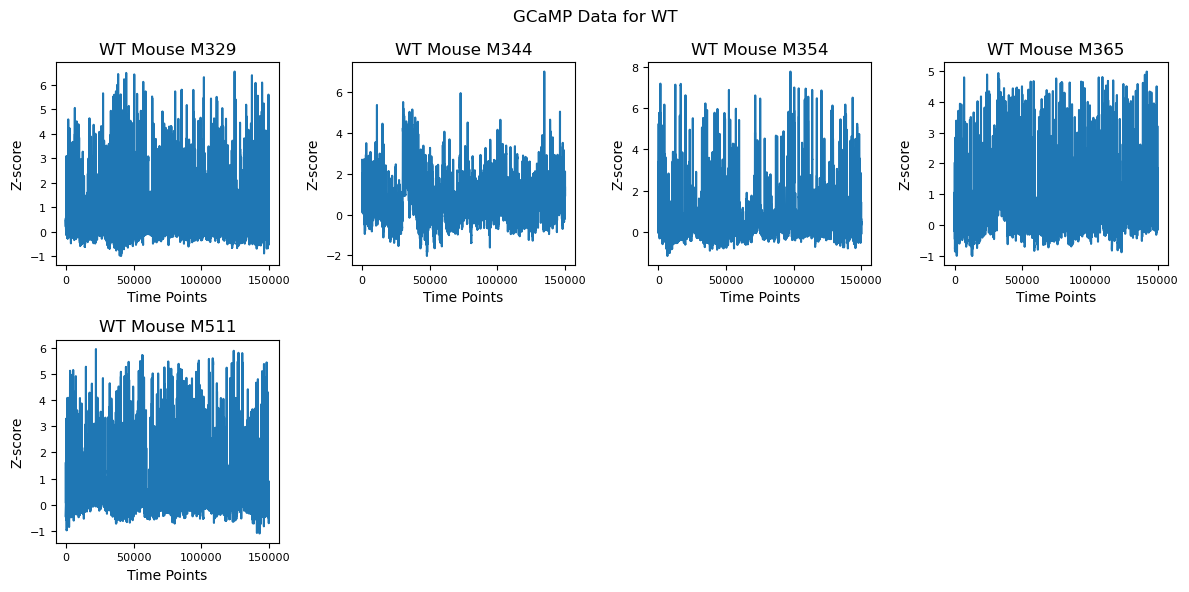

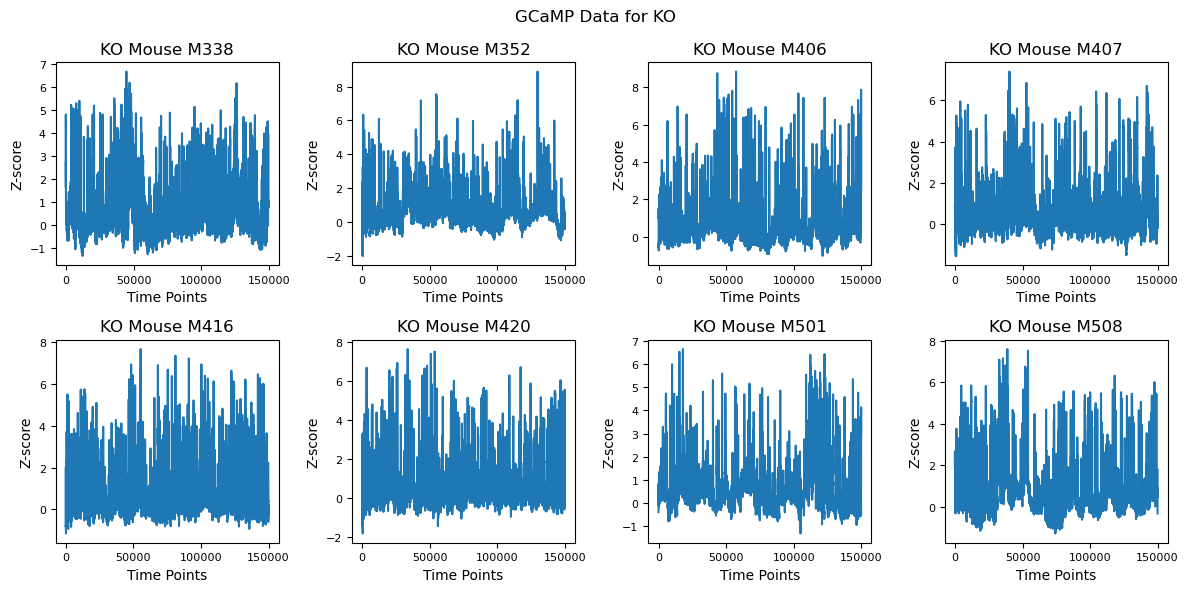

Combined results table for WT mice:
     mouse_id event peak_index  peak_time_s  event_window_start  \
0        M365     1        146         2.92          121.230441   
1        M354     1        238         4.76          178.868322   
2        M511     1        239         4.78          219.645079   
3        M365     2        330         6.60          300.161920   
4        M354     2        377         7.54          361.678369   
...       ...   ...        ...          ...                 ...   
1327     M365   307     149370      2987.40       149347.329990   
1328     M329   301     149410      2988.20       149402.337404   
1329     M354   204     149435      2988.70       149412.309918   
1330     M329   302     149665      2993.30       149627.808546   
1331     M365   308     149760      2995.20       149738.477136   

      event_window_end  peak_amp     width_ms  inst_freq  isi_s      AUC  
0           192.717216  2.031316   579.735498        NaN    NaN   966.69  
1        

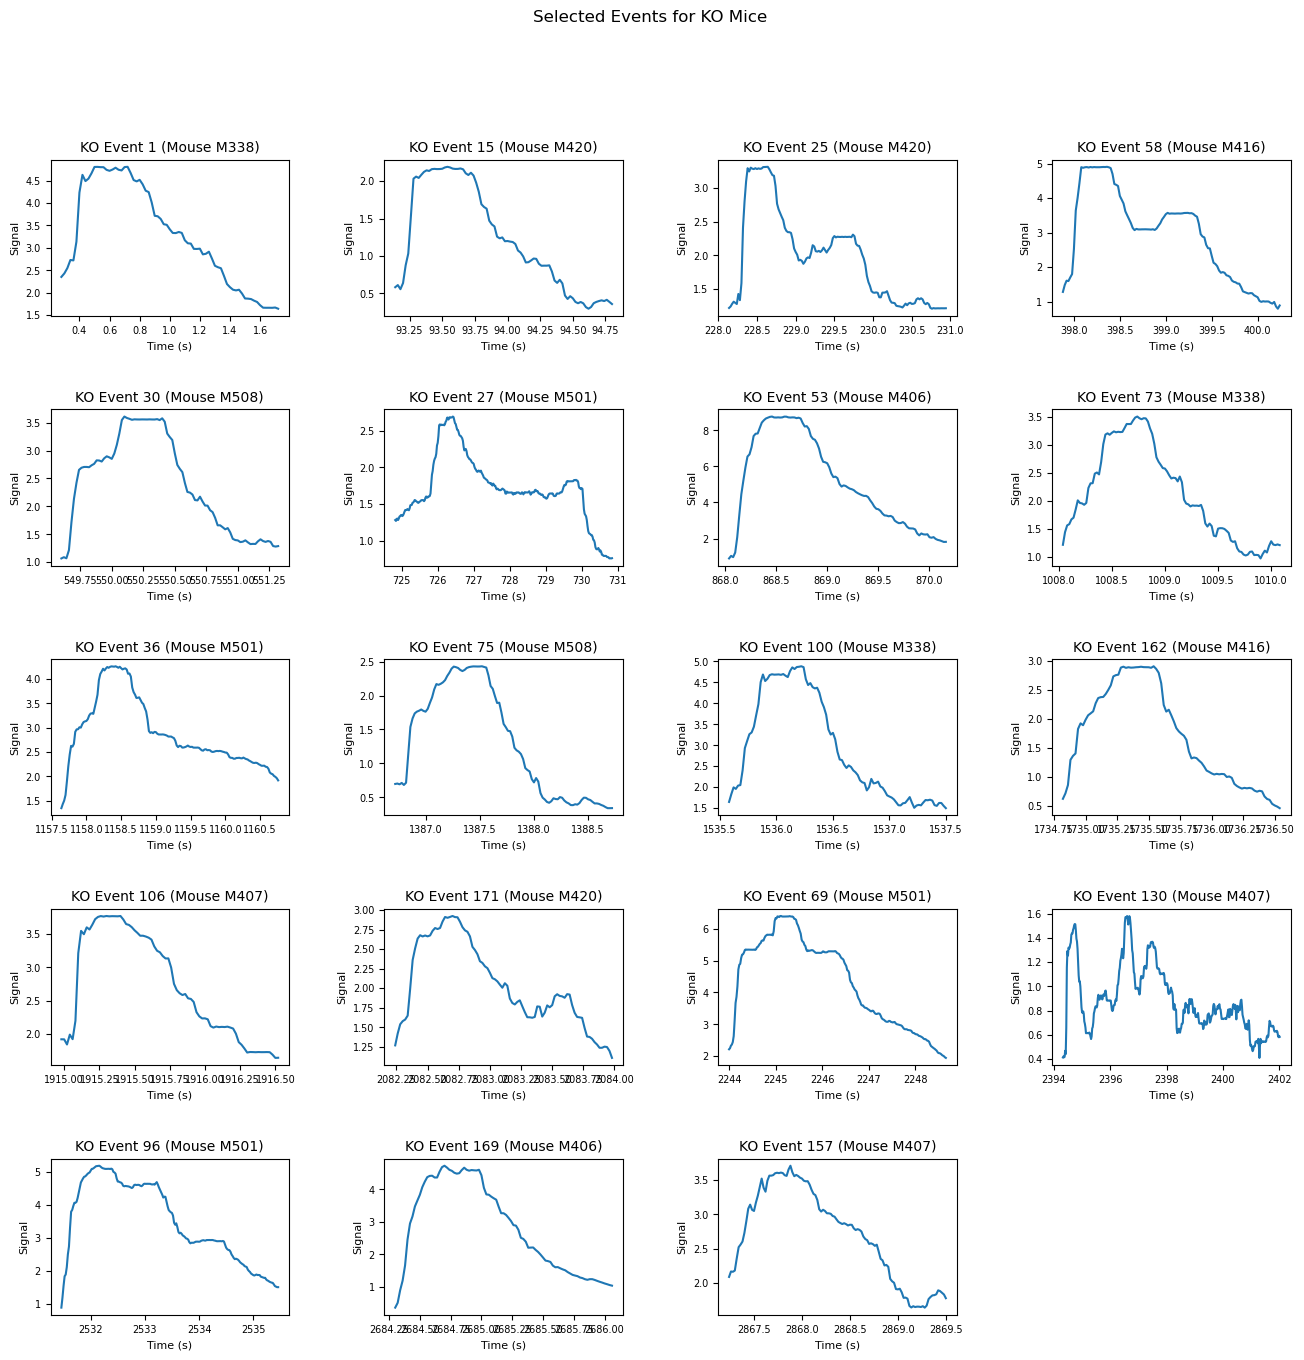

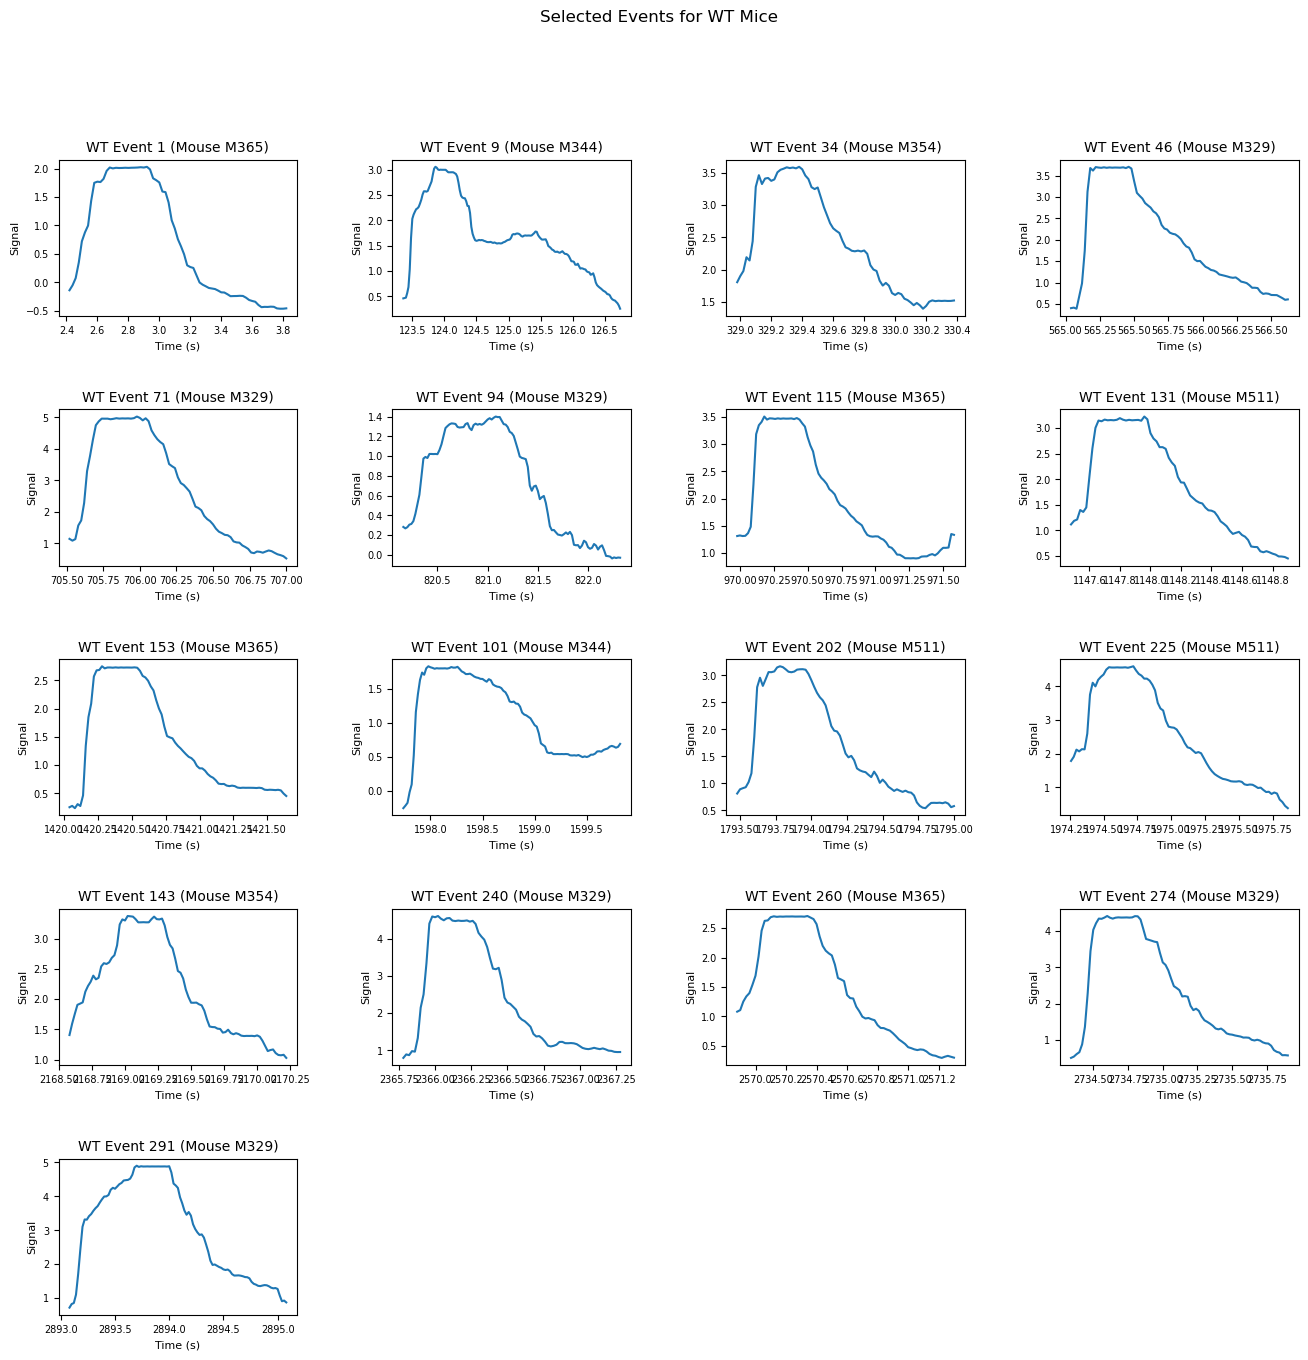


Peak statistics per bin for WT mice:
    mouse_id  bin_start  bin_end  peak_count  avg_amplitude  std_amplitude  \
0       M329          0     3000           7       3.271386       0.777758   
1       M329       3000     6000           5       2.767726       0.764248   
2       M329       6000     9000           7       3.621284       0.831215   
3       M329       9000    12000           4       3.438414       0.705980   
4       M329      12000    15000           4       2.748581       0.371944   
..       ...        ...      ...         ...            ...            ...   
245     M511     135000   138000           5       3.465605       0.154150   
246     M511     138000   141000          10       3.191774       0.684884   
247     M511     141000   144000           6       3.480817       1.002393   
248     M511     144000   147000           9       3.592694       1.068485   
249     M511     147000   150000           8       4.011009       1.044617   

     sem_amplitude  media

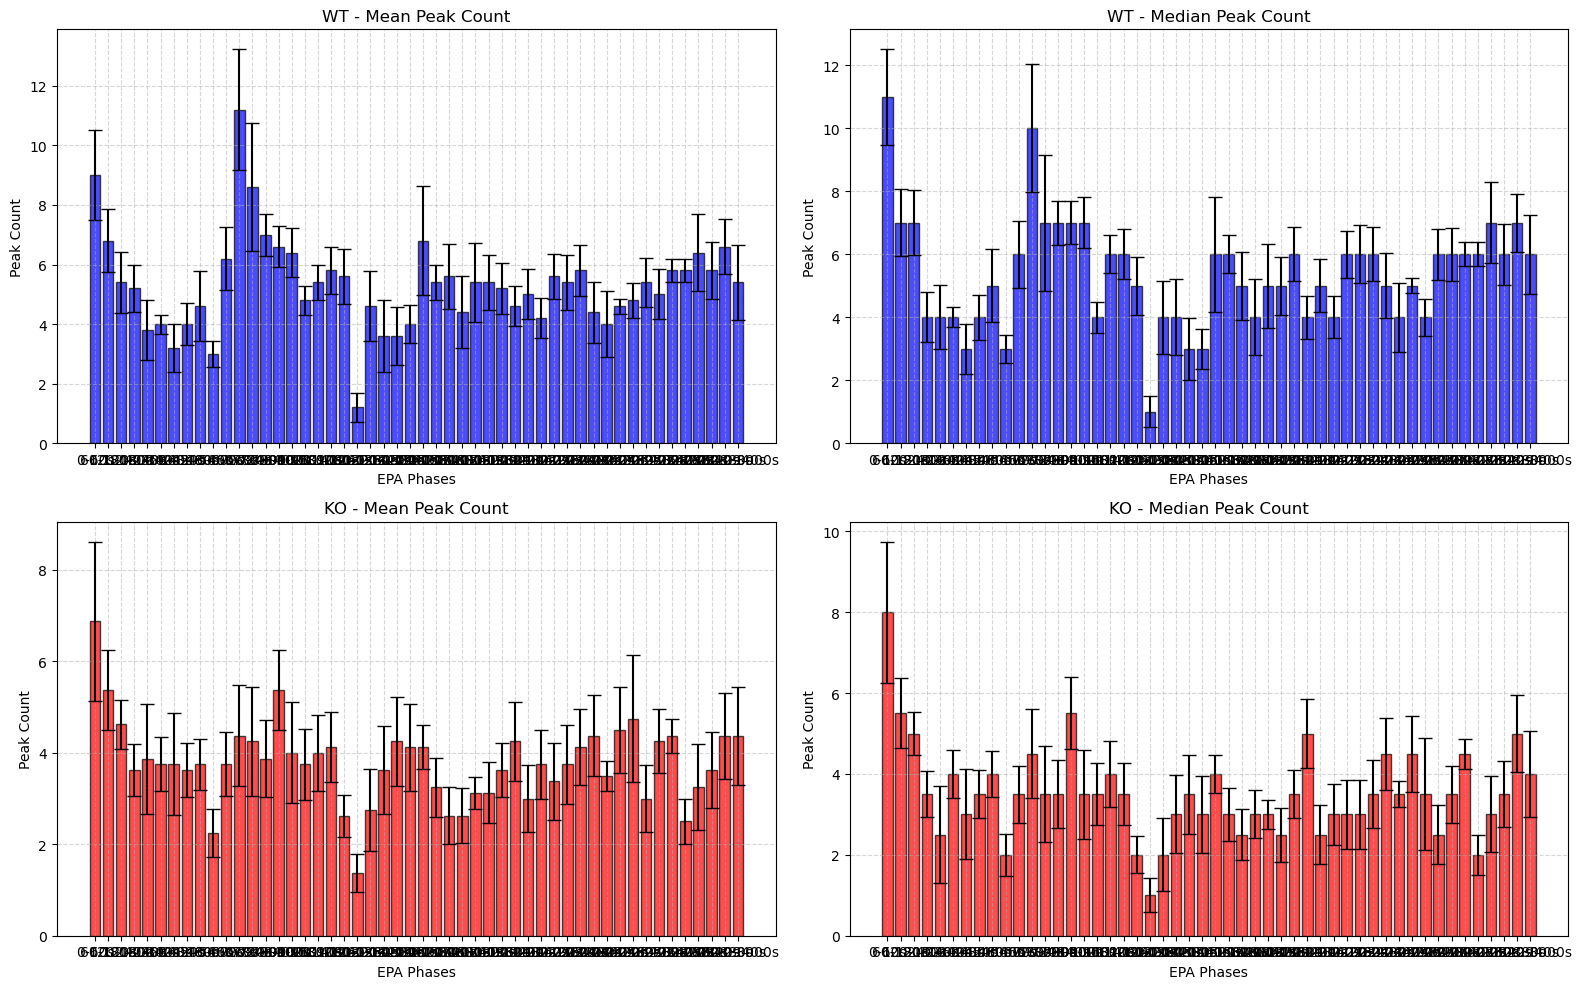

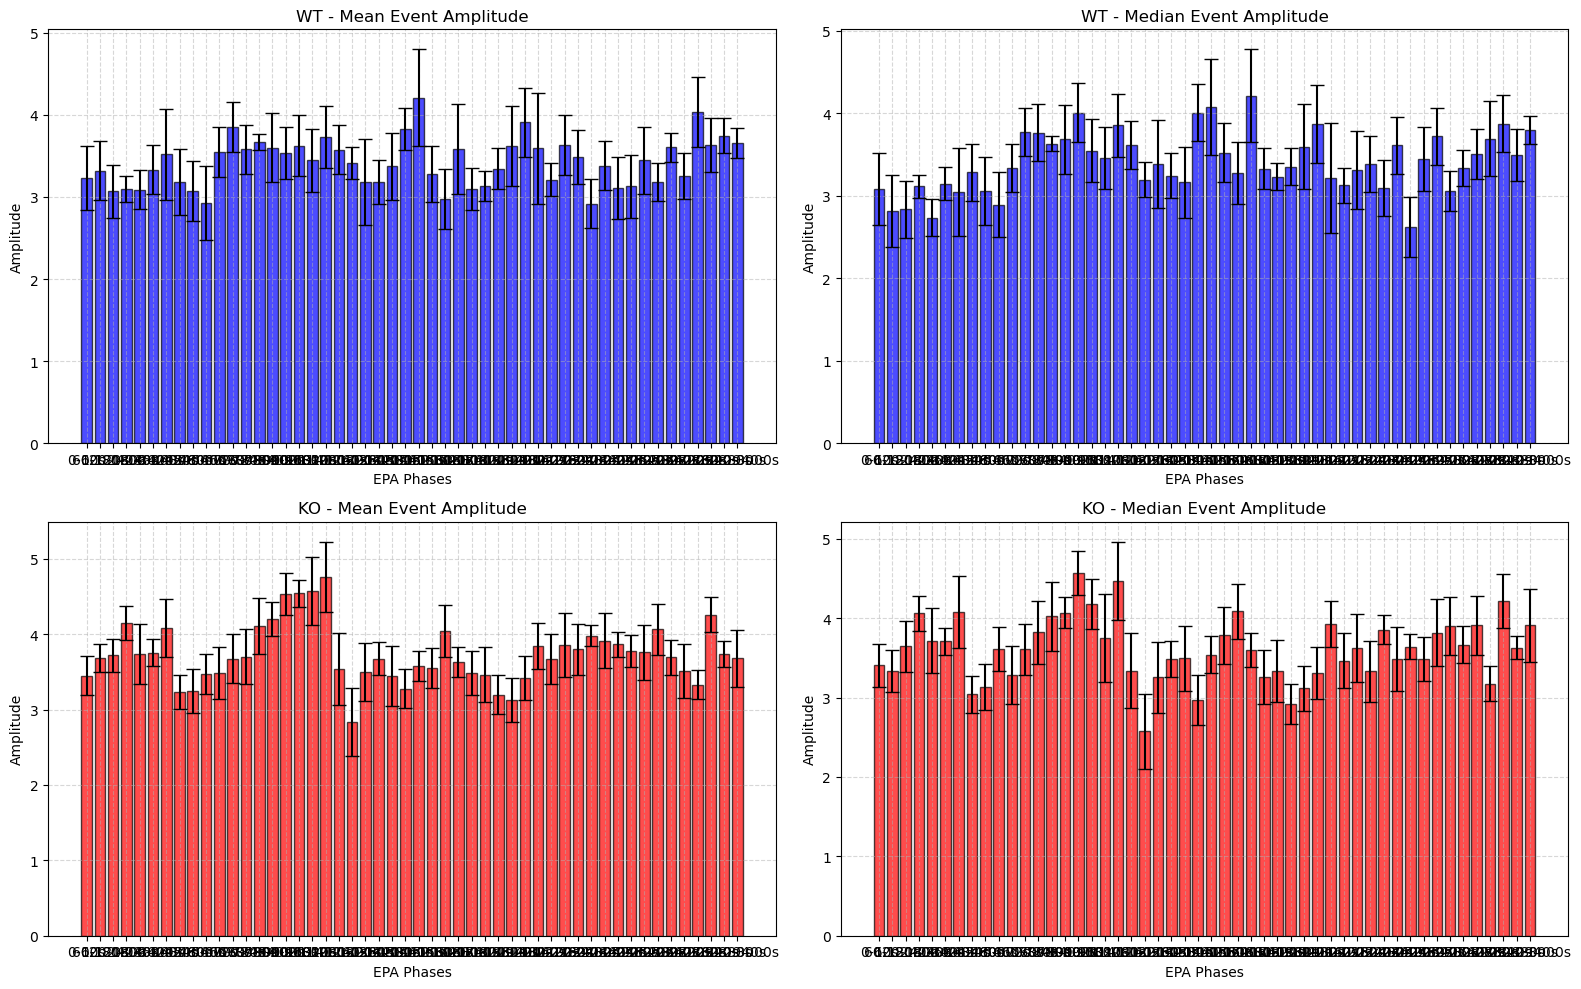

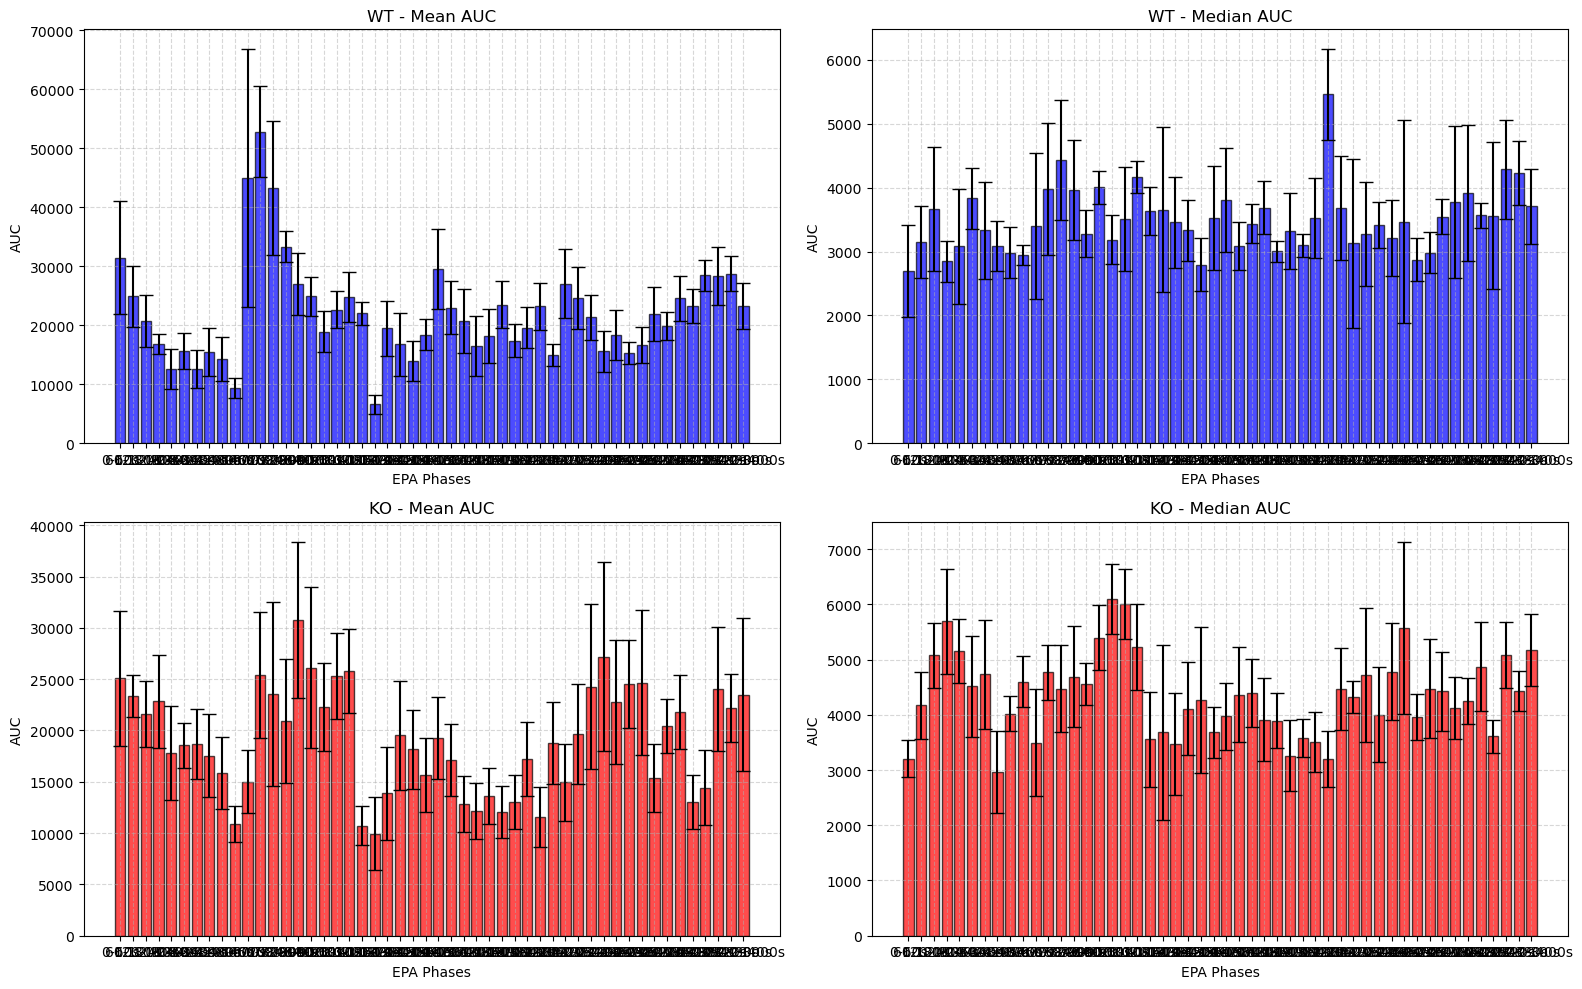

In [28]:
# MAIN ROUTINE
def main():
    experiments = load_experiments(DATA_FOLDER)
    group_WT, group_KO = separate_groups(experiments)
    
    filtered_WT = process_gcamp_data(group_WT)
    filtered_KO = process_gcamp_data(group_KO)
    print(f"Total WT mice with GCaMP data: {len(filtered_WT)}")
    print(f"Total KO mice with GCaMP data: {len(filtered_KO)}")
    plot_gcamp_data(filtered_WT, "WT")
    plot_gcamp_data(filtered_KO, "KO")
    
    wt_table = process_group_peaks(filtered_WT, "WT")
    ko_table = process_group_peaks(filtered_KO, "KO")
    
    plot_selected_events(ko_table, filtered_KO, "KO", event_step=80)
    plot_selected_events(wt_table, filtered_WT, "WT", event_step=80)
    
    wt_peak_stats_df = compute_peak_stats_per_bin(filtered_WT, "WT")
    ko_peak_stats_df = compute_peak_stats_per_bin(filtered_KO, "KO")
    wt_overall_peak_stats = compute_group_peak_stats(wt_peak_stats_df, "WT")
    ko_overall_peak_stats = compute_group_peak_stats(ko_peak_stats_df, "KO")
    
    wt_auc_stats_df = compute_auc_per_bin(filtered_WT, "WT")
    ko_auc_stats_df = compute_auc_per_bin(filtered_KO, "KO")
    wt_overall_auc_stats = compute_group_auc_stats(wt_auc_stats_df, "WT")
    ko_overall_auc_stats = compute_group_auc_stats(ko_auc_stats_df, "KO")
    
    wt_width_stats_df = compute_width_stats_per_bin(wt_table, "WT")
    ko_width_stats_df = compute_width_stats_per_bin(ko_table, "KO")
    
    plot_peak_count_stats(wt_overall_peak_stats, ko_overall_peak_stats)
    plot_amplitude_stats(wt_overall_peak_stats, ko_overall_peak_stats)
    plot_auc_stats(wt_overall_auc_stats, ko_overall_auc_stats)
    
    # # Save the group-level statistics to CSV files
    # save_group_stats(wt_overall_peak_stats, wt_overall_auc_stats, ko_overall_peak_stats, ko_overall_auc_stats) 
    
if __name__ == '__main__':
    main()
